**Basic Linear Regression Modeling For Bank Credit Dataset**


The selected dataset contains client data from a Portuguese bank's marketing campaign, aiming to predict whether a client will subscribe to a term deposit.

**Column Definitions:**


*   job:	Occupation
*   marital:	Marital status
*   education:	Education level
*   default:	Has credit in default? (yes/no)
*   balance:	Average yearly bank balance (in euros)
*   housing:	Has a housing loan? (yes/no)
*   loan:	Has a personal loan? (yes/no)
*   contact:	Contact communication type (cellular, telephone)
*   day:	Last contact day of the month
*   month:	Last contact month of the year
*   duration:	Duration of last contact in seconds
*   campaign:	Number of contacts during the current campaign
*   pdays:Days passed since last contact from a previous campaign (999 / -1 = no previous contact)
*  previous:	Number of contacts before this campaign
*  poutcome:	Outcome of the previous marketing campaign (success, failure, unknown)
*   target:	Has the client subscribed to a term deposit? (1 = no, 2 = yes)















  
  
  
  








In [1]:
# Import sklearn objects
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [2]:
!pip install openml
import openml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Access data with API Key
openml.config.apikey = 'd1d7d235b5af2860d5e4962ed225765e'

# Connect data
dataset = openml.datasets.get_dataset(1461)

# Construct dataFrame
data_tuple = dataset.get_data(target=dataset.default_target_attribute)

X = data_tuple[0]
y = data_tuple[1]
df = X.copy()

# Rename the columns
df.columns = [
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
    'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
    'previous', 'poutcome'
]

df['target'] = y

# Check dataframe
print(df.head(5))

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.4 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=d09e38f7c1f14009f160a24a37e43bc1c03d4ddb7ddd92feeb74f2fdfa27f450
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no   2143.0     yes   no   
1   44    technician   single  secondary      no     29.0     yes   no   
2   33  entrepreneur  married  secondary      no      2.0     yes  yes   
3   47   blue-collar  married    unknown      no   1506.0     yes   no   
4   33       unknown   single    unknown      no      1.0     

In [3]:
# Check for null and dublicates values
print(df.isnull().sum())
print(df.duplicated().sum())

# Check data statistics
print(df.describe())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
target       0
dtype: int64
0
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

         

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  uint8   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  float64 
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  uint8   
 10  month      45211 non-null  category
 11  duration   45211 non-null  float64 
 12  campaign   45211 non-null  uint8   
 13  pdays      45211 non-null  float64 
 14  previous   45211 non-null  float64 
 15  poutcome   45211 non-null  category
 16  target     45211 non-null  category
dtypes: category(10), float64(4), uint8(3)
memory usage: 1.9 MB


In [ ]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
  print(col,":", df[col].unique())

job : ['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', ..., 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
Length: 12
Categories (12, object): ['admin.' < 'blue-collar' < 'entrepreneur' < 'housemaid' ... 'student' <
                          'technician' < 'unemployed' < 'unknown']
marital : ['married', 'single', 'divorced']
Categories (3, object): ['divorced' < 'married' < 'single']
education : ['tertiary', 'secondary', 'unknown', 'primary']
Categories (4, object): ['primary' < 'secondary' < 'tertiary' < 'unknown']
default : ['no', 'yes']
Categories (2, object): ['no' < 'yes']
housing : ['yes', 'no']
Categories (2, object): ['no' < 'yes']
loan : ['no', 'yes']
Categories (2, object): ['no' < 'yes']
contact : ['unknown', 'cellular', 'telephone']
Categories (3, object): ['cellular' < 'telephone' < 'unknown']
month : ['may', 'jun', 'jul', 'aug', 'oct', ..., 'jan', 'feb', 'mar', 'apr', 'sep']
Length: 12
Categories (12, object): ['apr' < 'aug' < 'de

In [5]:
# Make target column binary regarding category values
df['target'] = df['target'].astype(str).str.strip()
df['target'] = df['target'].map({'1': 0, '2': 1})

df.target.unique()

array([0, 1])

In [6]:
# Converting pdays column into ordinal categories since it has mostly null values
print(df.pdays.isin([-1, 999]).sum())

def mapping_pdays(num):
    if num in [-1, 999]:
        return "no_contact"
    elif num <= 30:
        return "recent"
    elif num <= 90:
        return "1_3_months"
    else:
        return "over_3_months"

df['pdays_cat'] = df['pdays'].apply( mapping_pdays)
df = df.drop('pdays', axis=1)


# Filter ordinal categorical columns and determine order
ordinal_cols = ['education', 'month', 'poutcome','pdays_cat']
for x in ordinal_cols:
    df[x] = df[x].astype(str)
    df[x] = df[x].str.strip()

ordinal_order = [
    ['primary', 'secondary', 'tertiary', 'unknown'],
    ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
    ['failure', 'other', 'success', 'unknown'],
    ['no_contact', 'recent', '1_3_months', 'over_3_months']
]

# Apply ordinal encoding
encoder = OrdinalEncoder(categories=ordinal_order)
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

# Converting non-numeric variables into numeric variables
nominal_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact']

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)


# Split features and target
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

36954


In [7]:
# Check y value distribution
print(y.value_counts(normalize=True))

target
0    0.883015
1    0.116985
Name: proportion, dtype: float64


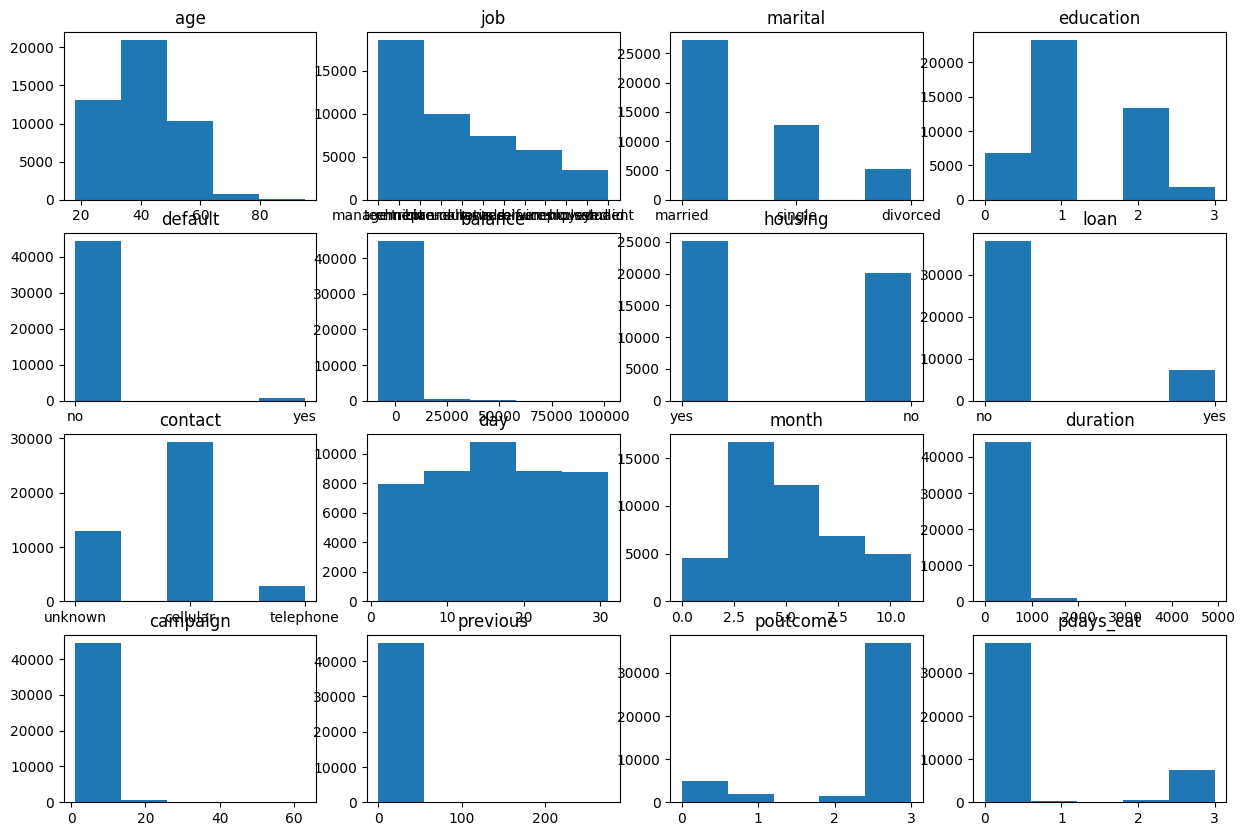

In [8]:
# Check x value distribution
import matplotlib.pyplot as plt

columns = df.drop("target", axis=1).columns

fig,ax = plt.subplots(4,4, figsize=(15, 10))

for i in range(4):
  for j in range(4):
    ax[i,j].hist(df[columns[i*4+j]],bins = 5 )
    ax[i, j].set_title(columns[i*4+j])

plt.show()

In [9]:
# Control correlation with y
corr = df_encoded.corr(numeric_only=True)['target'].sort_values(ascending=False)

print(corr)

target               1.000000
duration             0.394521
pdays_cat            0.161269
previous             0.093236
job_retired          0.079245
job_student          0.076897
education            0.066241
marital_single       0.063526
balance              0.052838
job_management       0.032919
age                  0.025155
job_unemployed       0.020390
month                0.018717
contact_telephone    0.014042
job_self-employed    0.000855
job_unknown          0.000267
job_technician      -0.008970
job_housemaid       -0.015195
job_entrepreneur    -0.019662
default_yes         -0.022419
job_services        -0.027864
day                 -0.028348
marital_married     -0.060260
loan_yes            -0.068185
job_blue-collar     -0.072083
campaign            -0.073172
poutcome            -0.077840
housing_yes         -0.139173
contact_unknown     -0.150935
Name: target, dtype: float64


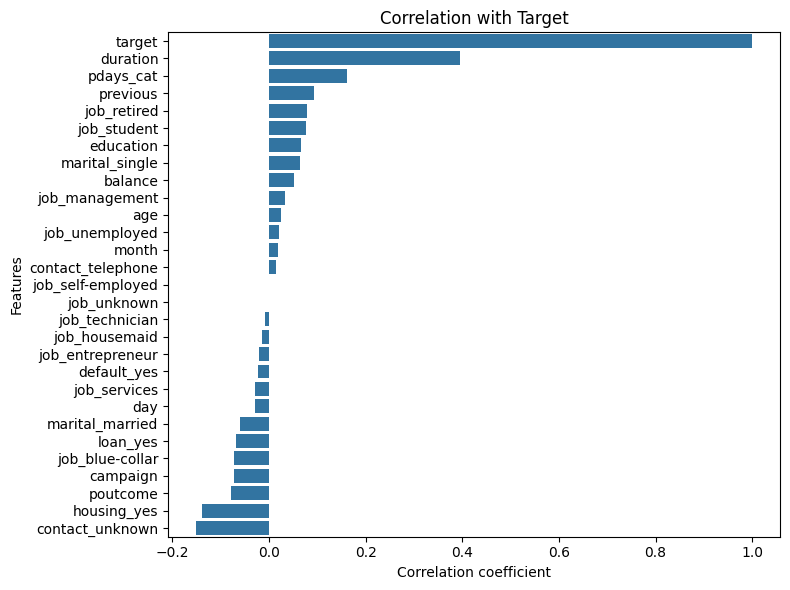

In [10]:
# Visualize
plt.figure(figsize=(8,6))
sns.barplot(x=corr.values, y=corr.index)
plt.title('Correlation with Target')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [11]:
# Determine and drop low correlated variables

print(X.shape)
low_corr_cols = corr[abs(corr) <= 0.05].index
X = X.drop(low_corr_cols, axis=1)
print(X.shape)

(45211, 28)
(45211, 15)


In [12]:
corr_matrix = df_encoded.corr(numeric_only=True)
high_corr = []

for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i!=j and abs(corr_matrix.loc[i,j]) > 0.8:
            pair = tuple(sorted((i,j)))
            if pair not in high_corr:
                high_corr.append(pair)

print(high_corr)

[('pdays_cat', 'poutcome')]


In [13]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [14]:
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [15]:
# Create pipeline for standardize + linear regression model
pipeline = Pipeline([('scaler',StandardScaler()), ('model', LinearRegression()) ])


# Executing K-Fold CV
kfold = KFold(shuffle=True, random_state = 42 )
negative_mse = cross_val_score(pipeline, X_train,y_train, cv = kfold,  scoring='neg_mean_squared_error')


# Calculate Rooted mse scores
rooted_mse_scores = np.sqrt(-negative_mse)


# Calculate r2 scores
r2_scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')

# Print the results
print("RMSE:", rooted_mse_scores)
print("mean RMSE:", rooted_mse_scores.mean())
print("R^2 Scores:", r2_scores)
print("Mean R^2:", r2_scores.mean())


RMSE: [0.27658807 0.28062002 0.26991976 0.27811497 0.28033513]
mean RMSE: 0.2771155903258976
R^2 Scores: [0.26374629 0.2358986  0.26964641 0.24096695 0.24681476]
Mean R^2: 0.25141460092945955


In [ ]:
# Fit the model and check the result with test set
#lm = LinearRegression()
#lm.fit(X_train, y_train)
#y_pred = lm.predict(X_test)

#mse = mean_squared_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)

#print(mse, r2)
#print(lm.coef_)

In [17]:
# Use the whole train test
pipeline.fit(X_train, y_train)

# Calculate the scores
y_pred_test = pipeline.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Test RMSE:", rmse_test)
print("Test R²:", r2_test)

Test RMSE: 0.280546634570075
Test R²: 0.25811931160951684


In [18]:
from sklearn.linear_model import Ridge

alphas = [0.01,0.1,1,10,100]
results = []

for alpha in alphas:
  pipeline = Pipeline([('scaler', StandardScaler()),('model', Ridge(alpha=alpha))])
  negative_mse = cross_val_score(pipeline,X_train,y_train, cv=kfold, scoring = 'neg_mean_squared_error')
  rmse = np.sqrt(-negative_mse).mean()
  results.append((alpha, rmse))

for alpha, score in results:
    print(f"alpha: {alpha}, mean RMSE: {score}")

alpha: 0.01, mean RMSE: 0.2771155909977474
alpha: 0.1, mean RMSE: 0.27711559706477884
alpha: 1, mean RMSE: 0.277115659750821
alpha: 10, mean RMSE: 0.27711648594914495
alpha: 100, mean RMSE: 0.2771426220227763


In [19]:
from sklearn.linear_model import Lasso

alphas = [0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=alpha, max_iter=10000))
    ])

    kfold = KFold(shuffle=True, random_state=42)
    negative_mse = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-negative_mse)

    print(f"alpha: {alpha}, mean RMSE: {rmse.mean()}")

alpha: 0.01, mean RMSE: 0.28364037625950766
alpha: 0.1, mean RMSE: 0.311000386289709
alpha: 1, mean RMSE: 0.3203019632192062
alpha: 10, mean RMSE: 0.3203019632192062
alpha: 100, mean RMSE: 0.3203019632192062


In [20]:
lasso_best = Lasso(alpha=0.01, max_iter=10000)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_train)
lasso_best.fit(X_scaled, y_train)


lasso_coeffs = pd.Series(lasso_best.coef_, index=X_train.columns)

zeroed_features = lasso_coeffs[lasso_coeffs == 0]
print("Zero features:")
print(zeroed_features)

Zero features:
balance     0.0
campaign   -0.0
previous    0.0
dtype: float64
